In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN custom operations

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  

from sklearn.model_selection import train_test_split

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
print(f"TensorFlow version: {tf.__version__}")

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D, MaxPooling2D, 
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array



TensorFlow version: 2.15.0
TensorFlow version: 2.15.0


In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images")
print("Dataset path:", dataset_path)
data_dir = os.path.join(dataset_path, "Shoe vs Sandal vs Boot Dataset")
categories = os.listdir(data_dir)
print("Categories:", categories)

Dataset path: C:\Users\user\.cache\kagglehub\datasets\hasibalmuzdadid\shoe-vs-sandal-vs-boot-dataset-15k-images\versions\2
Categories: ['Boot', 'Sandal', 'Shoe']
Dataset path: C:\Users\user\.cache\kagglehub\datasets\hasibalmuzdadid\shoe-vs-sandal-vs-boot-dataset-15k-images\versions\2
Categories: ['Boot', 'Sandal', 'Shoe']


In [3]:
directory = data_dir
categories = ["Boot", "Sandal", "Shoe"]

filenames = []
category_labels = []

for category in categories:
    category_folder = os.path.join(directory, category)
    category_filenames = os.listdir(category_folder)
    filenames.extend([os.path.join(category, fname) for fname in category_filenames])
    category_labels.extend([category] * len(category_filenames))

df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

print(df.head())


               filename category
0     Boot\boot (1).jpg     Boot
1    Boot\boot (10).jpg     Boot
2   Boot\boot (100).jpg     Boot
3  Boot\boot (1000).jpg     Boot
4  Boot\boot (1001).jpg     Boot


In [4]:
filenames = np.array(filenames)
labels = np.array(category_labels)
print(labels)

['Boot' 'Boot' 'Boot' ... 'Shoe' 'Shoe' 'Shoe']


In [5]:
import splitfolders

# Create dataset/split_data in the project root folder
project_root = os.path.dirname(os.getcwd())  # Go up from notebook/ to project root
dataset_folder = os.path.join(project_root, 'dataset')
output_folder = os.path.join(dataset_folder, 'split_data')

# Split the data: 80% train, 10% val, 10% test
splitfolders.ratio(
    data_dir,  # Source: Kaggle dataset
    output=output_folder,  # Destination: project_root/dataset/split_data/
    seed=42,
    ratio=(0.8, 0.1, 0.1)
)

print(f"Data split completed!")
print(f"Output folder: {output_folder}")
print(f"Folders created: {os.listdir(output_folder)}")

Copying files: 15000 files [00:36, 415.69 files/s]

Data split completed!
Output folder: c:\Users\user\Documents\alumachinelearning\year3 ALU\pipeline_summative\dataset\split_data
Folders created: ['test', 'train', 'val']


# Data Exploration and Visualization

Let's explore the dataset structure and visualize sample images from each category.

Total categories: 3
Boot: 5000 images
Sandal: 5000 images
Shoe: 5000 images


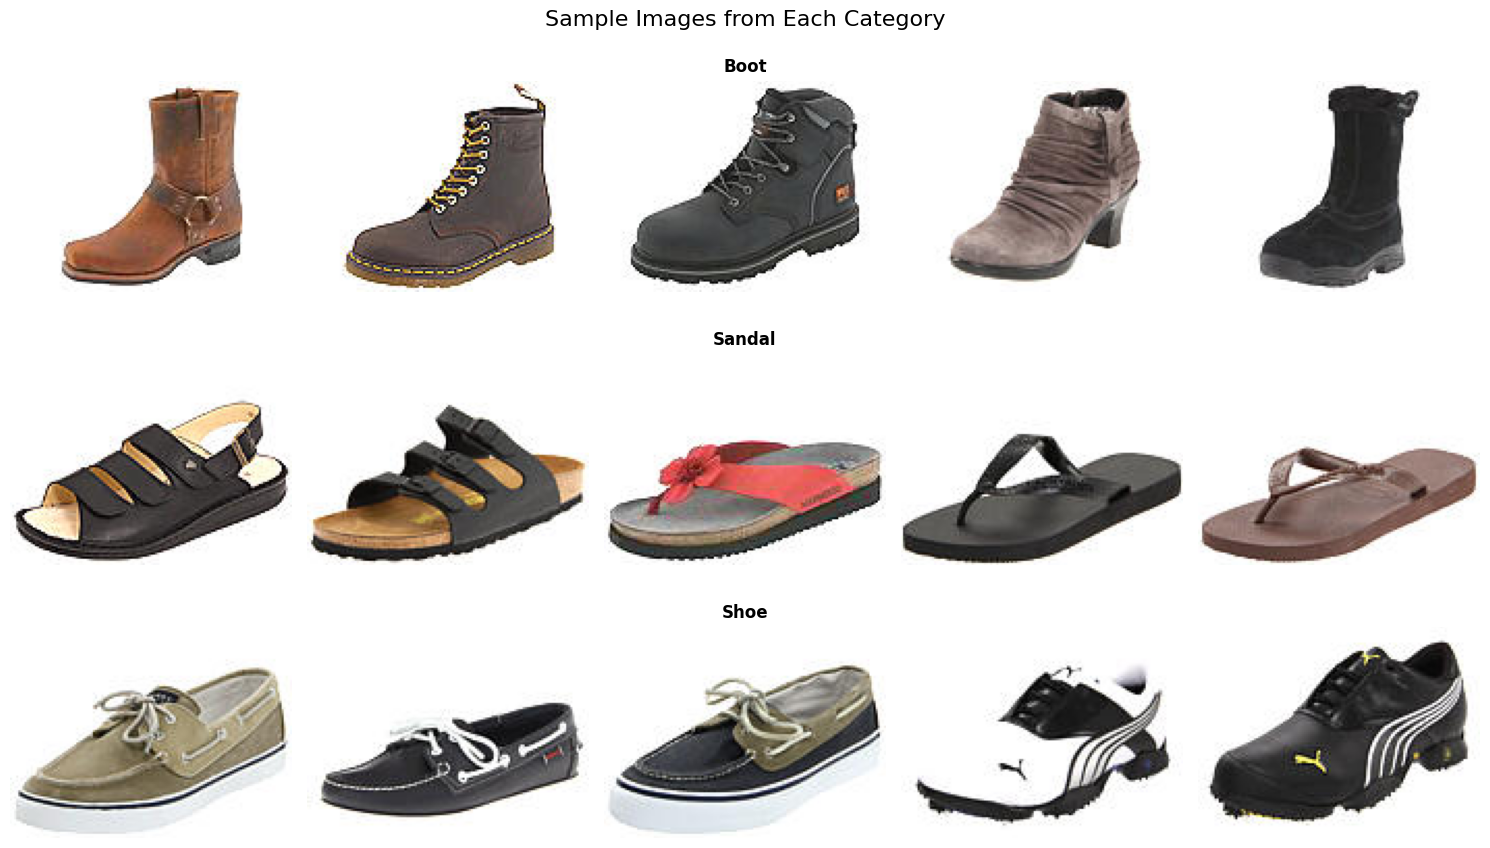

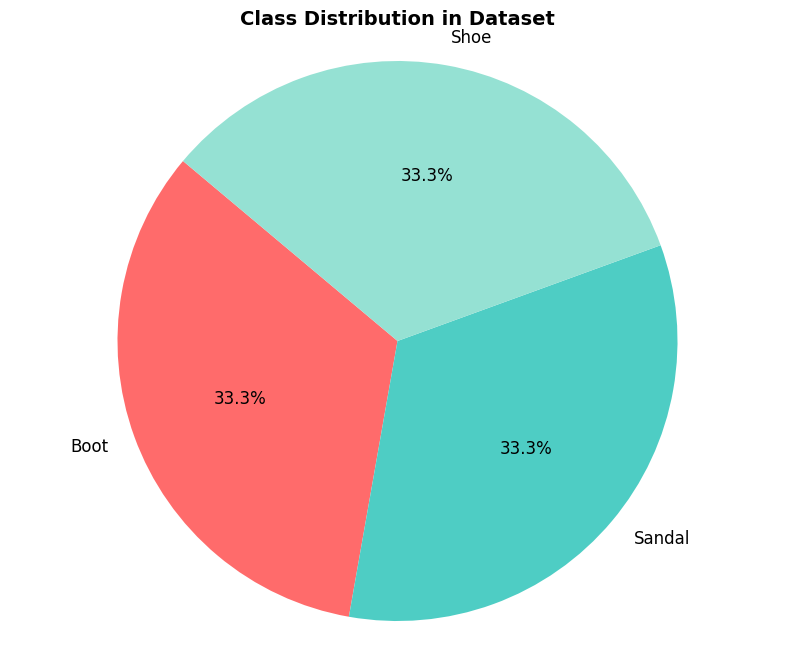


Class Distribution:
  Boot: 5000 images (33.33%)
  Sandal: 5000 images (33.33%)
  Shoe: 5000 images (33.33%)


In [6]:
# Explore dataset structure
print(f"Total categories: {len(categories)}")
for category in categories:
    category_folder = os.path.join(data_dir, category)
    num_images = len(os.listdir(category_folder))
    print(f"{category}: {num_images} images")

# Visualize sample images from each category
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Images from Each Category', fontsize=16)

for i, category in enumerate(categories):
    category_folder = os.path.join(data_dir, category)
    images = os.listdir(category_folder)[:5]
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(category_folder, img_name)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 2:
            axes[i, j].set_title(category, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Showing class distribution as pie chart
class_counts = {}
for category in categories:
    category_folder = os.path.join(data_dir, category)
    class_counts[category] = len(os.listdir(category_folder))

labels = list(class_counts.keys())
sizes = list(class_counts.values())
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

# statistics
total = sum(sizes)
print("\nClass Distribution:")
for lbl, sz in zip(labels, sizes):
    print(f"  {lbl}: {sz} images ({sz/total:.2%})")

In [7]:
true_labels = df['category'].values
true_labels

array(['Boot', 'Boot', 'Boot', ..., 'Shoe', 'Shoe', 'Shoe'], dtype=object)

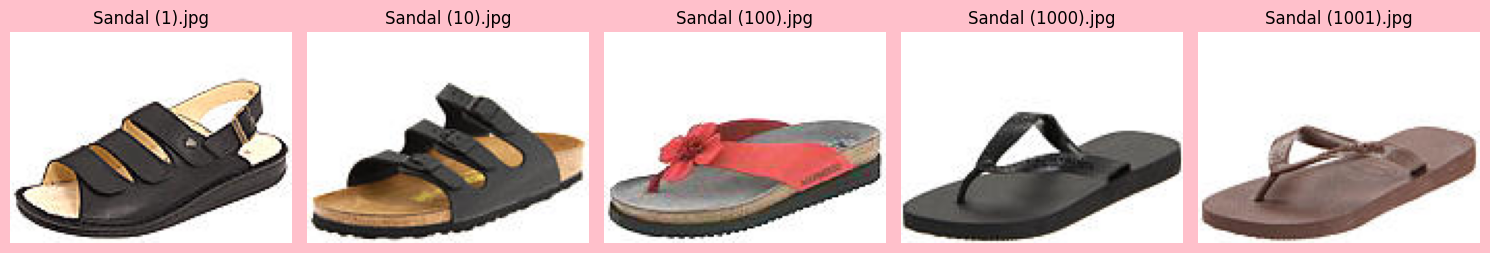

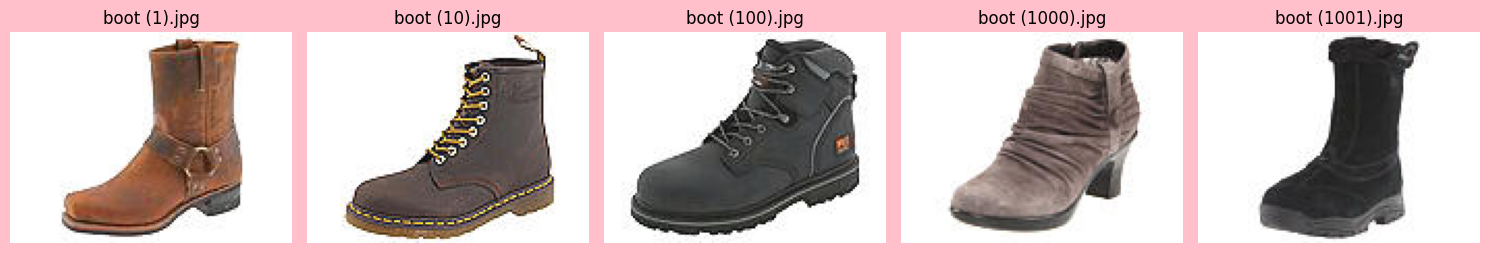

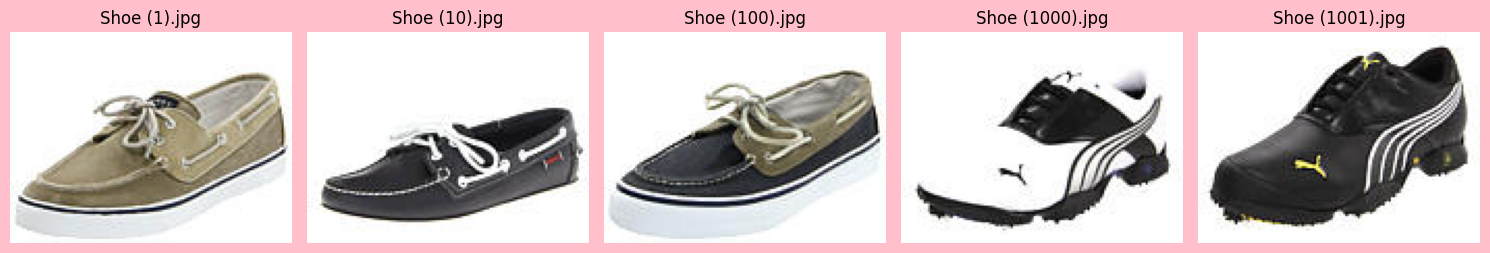

In [8]:
def visualize_images(path, num_images=5):
    image_filenames = os.listdir(path)
    
    num_images = min(num_images, len(image_filenames))
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='pink')
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        axes[i].imshow(image)
        axes[i].axis('off')  
        axes[i].set_title(image_filename) 
    
    plt.tight_layout()
    plt.show()
visualize_images(os.path.join(data_dir, 'sandal'))
visualize_images(os.path.join(data_dir, 'boot'))
visualize_images(os.path.join(data_dir, 'shoe'))

### Data augmentation

In [9]:
# Use the split_data folder structure
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

batch_size = 32
image_size = (128, 128)
SEED = 123

# Enhanced Image Generator augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,          
    width_shift_range=0.15,     
    height_shift_range=0.15,     
    shear_range=0.1,           
    zoom_range=0.15,            
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'        
)

# Validation and test: only rescaling (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=SEED
)

validation_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=SEED
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=SEED
)

print(f"\n✓ Data generators created:")
print(f"  Train: {train_ds.samples} samples")
print(f"  Val: {validation_ds.samples} samples")
print(f"  Test: {test_ds.samples} samples")

# Check class balance
print(f"\n✓ Class balance check:")
print(f"Training set:")
for class_name, class_count in train_ds.class_indices.items():
    count = sum(train_ds.classes == class_count)
    print(f"  {class_name}: {count} images ({count/train_ds.samples*100:.1f}%)")

print(f"\nValidation set:")
for class_name, class_count in validation_ds.class_indices.items():
    count = sum(validation_ds.classes == class_count)
    print(f"  {class_name}: {count} images ({count/validation_ds.samples*100:.1f}%)")

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.

✓ Data generators created:
  Train: 12000 samples
  Val: 1500 samples
  Test: 1500 samples

✓ Class balance check:
Training set:
  Boot: 4000 images (33.3%)
  Sandal: 4000 images (33.3%)
  Shoe: 4000 images (33.3%)

Validation set:
  Boot: 500 images (33.3%)
  Sandal: 500 images (33.3%)
  Shoe: 500 images (33.3%)

✓ Data generators created:
  Train: 12000 samples
  Val: 1500 samples
  Test: 1500 samples

✓ Class balance check:
Training set:
  Boot: 4000 images (33.3%)
  Sandal: 4000 images (33.3%)
  Shoe: 4000 images (33.3%)

Validation set:
  Boot: 500 images (33.3%)
  Sandal: 500 images (33.3%)
  Shoe: 500 images (33.3%)


In [10]:
# Setting image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64  

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80-20 train-val split
)

# Only rescaling for validation set
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Create validation generator
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Steps per epoch: {len(train_generator)} (batch size: {BATCH_SIZE})")

# Store class names for model evaluation
model_class_names = list(train_ds.class_indices.keys())
print(f"\nModel will use classes: {model_class_names}")

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Classes: ['Boot', 'Sandal', 'Shoe']
Training samples: 12000
Validation samples: 3000
Steps per epoch: 188 (batch size: 64)

Model will use classes: ['Boot', 'Sandal', 'Shoe']
Classes: ['Boot', 'Sandal', 'Shoe']
Training samples: 12000
Validation samples: 3000
Steps per epoch: 188 (batch size: 64)

Model will use classes: ['Boot', 'Sandal', 'Shoe']


# Model Building with Transfer Learning

Using CNN model with custom layers, regularization, and optimization techniques.

In [ ]:


model = Sequential(name='CNN_shoe_model')

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), 
                 kernel_initializer=HeNormal(), input_shape=(128, 128, 3), name='CONV_Layer1'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', 
                 kernel_initializer=HeNormal(), name='CONV_Layer2'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', 
                 kernel_initializer=HeNormal(), name='CONV_Layer3'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten(name='Flatten'))

model.add(Dense(220, activation='relu', kernel_initializer=HeNormal(), name='FullyConnected1'))
model.add(Dense(64,activation="relu"))

model.add(Dense(3, activation='softmax', kernel_initializer=HeNormal(), name='OutputLayer'))

model.summary()



NameError: name 'Sequential' is not defined

In [ ]:
model.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

# Model Training with Early Stopping

Training the model with early stopping to prevent overfitting.

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# Training the model
EPOCHS = 15

print("Starting training...")
print(f"Total training samples: {train_ds.samples}")
print(f"Total validation samples: {validation_ds.samples}")
print(f"Steps per epoch: {len(train_ds)}")
print(f"This will take approximately {len(train_ds) * EPOCHS / 60:.1f} minutes\n")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[early_stopping],
    verbose=1
)

print("\nTraining completed!")

# Evaluate on validation set
print("\n" + "="*60)
print("VALIDATION EVALUATION")
print("="*60)

validation_ds.reset()
y_true_all = []
y_pred_all = []

for i in range(len(validation_ds)):
    X_batch, y_batch = next(validation_ds)
    y_true = np.argmax(y_batch, axis=1)
    y_pred = np.argmax(model.predict(X_batch, verbose=0), axis=1)
    
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

print(f"Accuracy : {accuracy_score(y_true_all, y_pred_all):.4f}")
print(f"Precision: {precision_score(y_true_all, y_pred_all, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_true_all, y_pred_all, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_true_all, y_pred_all, average='weighted'):.4f}")
print("="*60)

Starting training...
Total training samples: 12000
Total validation samples: 1500
Steps per epoch: 375
This will take approximately 93.8 minutes

Epoch 1/15
Epoch 1/15
375/375 [==============================] - 379s 1s/step - loss: 0.7323 - accuracy: 0.7092 - val_loss: 0.8304 - val_accuracy: 0.6867
Epoch 2/15
375/375 [==============================] - 379s 1s/step - loss: 0.7323 - accuracy: 0.7092 - val_loss: 0.8304 - val_accuracy: 0.6867
Epoch 2/15
375/375 [==============================] - 191s 510ms/step - loss: 0.5187 - accuracy: 0.8127 - val_loss: 1.2468 - val_accuracy: 0.6020
Epoch 3/15
375/375 [==============================] - 191s 510ms/step - loss: 0.5187 - accuracy: 0.8127 - val_loss: 1.2468 - val_accuracy: 0.6020
Epoch 3/15
375/375 [==============================] - 2800s 7s/step - loss: 0.4285 - accuracy: 0.8516 - val_loss: 0.3621 - val_accuracy: 0.8787
Epoch 4/15
Epoch 4/15
375/375 [==============================] - 188s 502ms/step - loss: 0.3781 - accuracy: 0.8753 - val_

# Training History Visualization

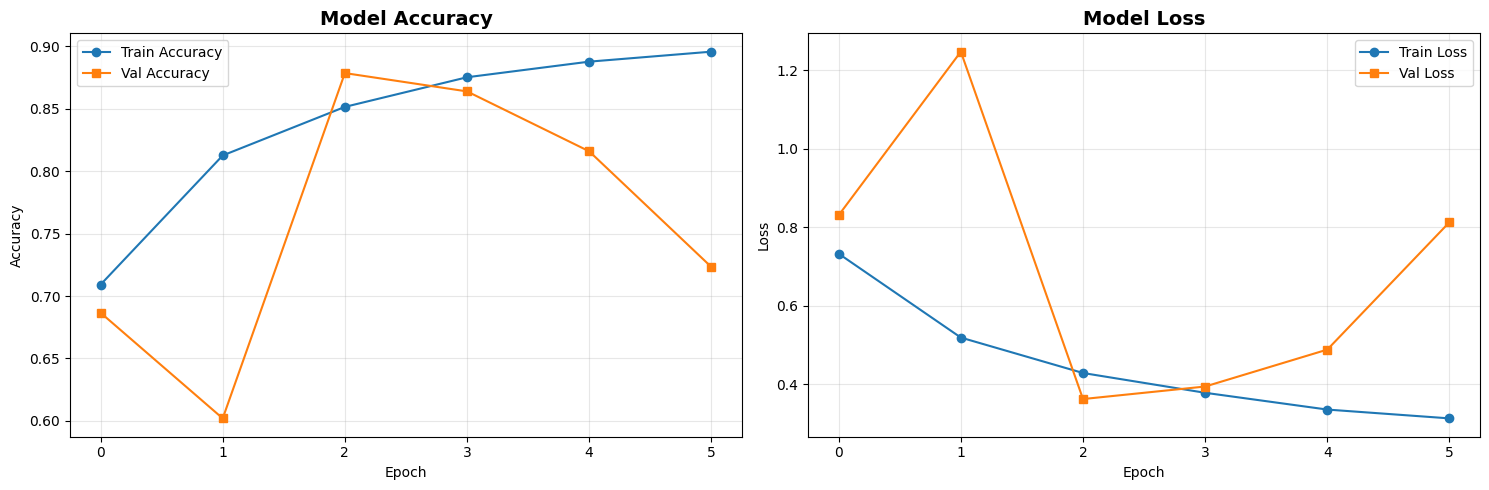

In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model Evaluation with Multiple Metrics

Evaluating the model using Accuracy, Loss, Precision, Recall, F1-Score, and Confusion Matrix.

47/47 [==============================] - 5s 110ms/step - loss: 0.3621 - accuracy: 0.8787

MODEL EVALUATION RESULTS
Loss: 0.3621
Accuracy: 0.8787

MODEL EVALUATION RESULTS
Loss: 0.3621
Accuracy: 0.8787
47/47 [==============================] - 5s 106ms/step
Precision: 0.3444
Recall: 0.3420
F1-Score: 0.3405

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Boot       0.33      0.37      0.35       500
      Sandal       0.36      0.28      0.32       500
        Shoe       0.34      0.38      0.36       500

    accuracy                           0.34      1500
   macro avg       0.34      0.34      0.34      1500
weighted avg       0.34      0.34      0.34      1500

Precision: 0.3444
Recall: 0.3420
F1-Score: 0.3405

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Boot       0.33      0.37      0.35       500
      Sandal       0.36      0.28      0.32       500
        Shoe       0.34      0.38      0.36       500


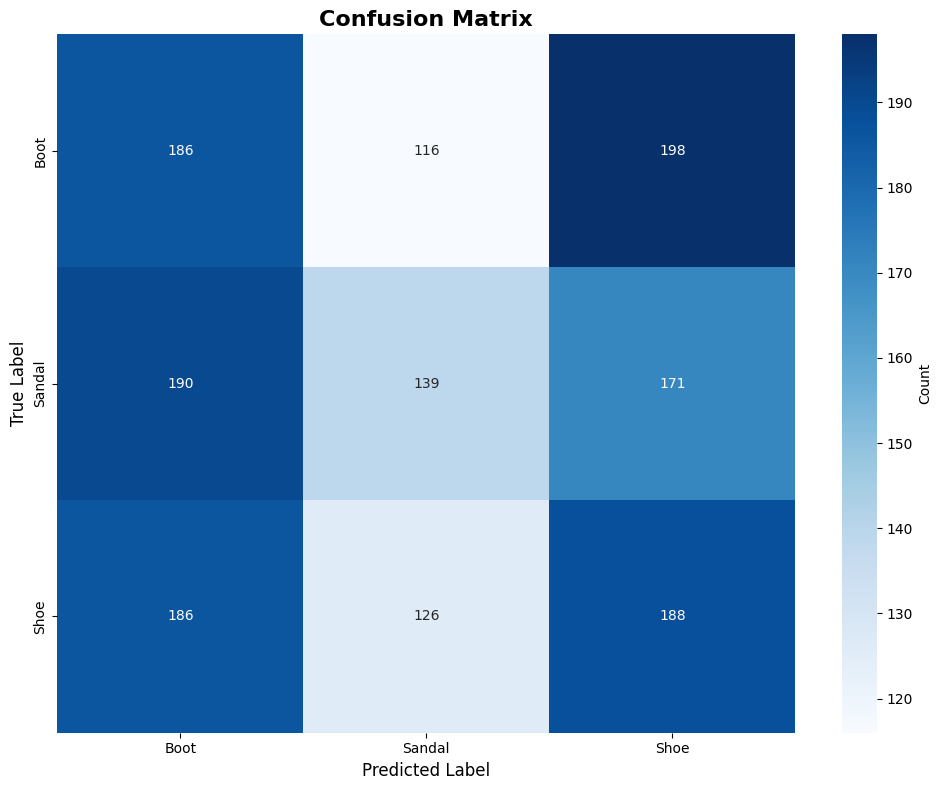

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Evaluate on validation set
validation_ds.reset()
eval_results = model.evaluate(validation_ds, verbose=1)

print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(f"Loss: {eval_results[0]:.4f}")
print(f"Accuracy: {eval_results[1]:.4f}")

# Get predictions for confusion matrix and classification report
validation_ds.reset()
y_pred_probs = model.predict(validation_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = validation_ds.classes

# Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("="*60)

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=model_class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model_class_names, yticklabels=model_class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Save the Model

Save the trained model for deployment and retraining.

In [16]:

import json

models_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')
os.makedirs(models_dir, exist_ok=True)

# Saving the model
model_path = os.path.join(models_dir, 'shoe_classifier_model.h5')
model.save(model_path)
print(f"Model saved to: {model_path}")

# Saving class names
class_names_path = os.path.join(models_dir, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(model_class_names, f)
print(f"Class names saved to: {class_names_path}")

Model saved to: c:\Users\user\Documents\alumachinelearning\year3 ALU\pipeline_summative\models\shoe_classifier_model.h5
Class names saved to: c:\Users\user\Documents\alumachinelearning\year3 ALU\pipeline_summative\models\class_names.json


# Test Prediction Function

Function to predict on new images.

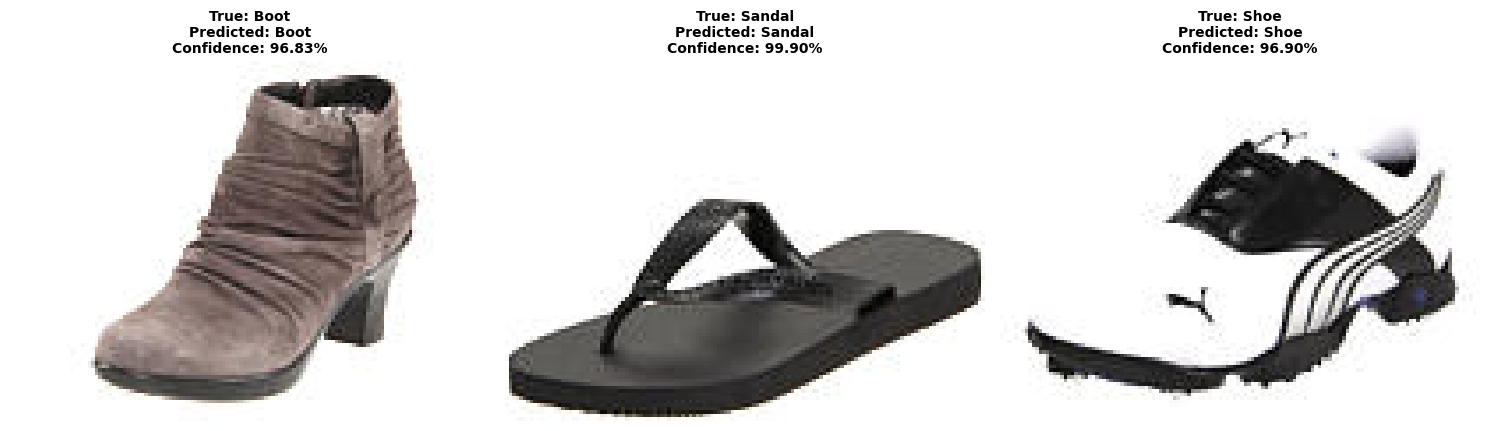


Prediction Probabilities:

Boot:
  Boot: 96.83%
  Sandal: 1.74%
  Shoe: 1.43%

Sandal:
  Boot: 0.01%
  Sandal: 99.90%
  Shoe: 0.09%

Shoe:
  Boot: 0.27%
  Sandal: 2.83%
  Shoe: 96.90%

Shoe:
  Boot: 0.27%
  Sandal: 2.83%
  Shoe: 96.90%


In [17]:
def predict_image(image_path, model, class_names):
    """
    Predict the class of a single image
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    
    return predicted_class, confidence, predictions[0]

# Test with sample images from the test set
test_dir_path = os.path.join(output_folder, 'test')
test_categories = os.listdir(test_dir_path)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, category in enumerate(test_categories):
    category_folder = os.path.join(test_dir_path, category)
    test_images = os.listdir(category_folder)
    test_image = test_images[0]  # Pick first test image
    test_image_path = os.path.join(category_folder, test_image)
    
    # Predict
    pred_class, confidence, probs = predict_image(test_image_path, model, model_class_names)
    
    # Display
    img = mpimg.imread(test_image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'True: {category}\nPredicted: {pred_class}\nConfidence: {confidence:.2f}%',
                      fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Show prediction probabilities
print("\nPrediction Probabilities:")
for i, category in enumerate(test_categories):
    category_folder = os.path.join(test_dir_path, category)
    test_images = os.listdir(category_folder)
    test_image = test_images[0]
    test_image_path = os.path.join(category_folder, test_image)
    
    pred_class, confidence, probs = predict_image(test_image_path, model, model_class_names)
    
    print(f"\n{category}:")
    for j, cls in enumerate(model_class_names):
        print(f"  {cls}: {probs[j]*100:.2f}%")